In [1]:
import sys
sys.path.append(r"I:/1-ML/Base")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, FNO2d, weight_init
from utils.DataGenerate_FNO import Dataset_FNO, Normalize, InNormalize, get_file
from argparse import Namespace
from utils.utilities3 import *
import time

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:

dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

config = Namespace(
	project_name = 'FNO',
	epochs = 100,
	
	dx = dx,
	n_x = n_x,
	n_y = n_y,
	p_x = p_x,
	p_y = p_y,
	self_split = self_split,

	path_trained_model = r'trained_model',
	path_distance = r'../train_data/distance',
	path_label = r'../train_data/label',
	path_distance_test = r'../test_data/distance',
	path_label_test = r'../test_data/label',

	batch_size = 150,
	modes = 12,
	width = 40,

	activation = 'Sigmoid',
# activation = torch.nn.__dict__[wandb.config.activation]()
# optimizer = torch.optim.__dict__[wandb.config.optim_type](params=model.parameters(), lr=wandb.config.learning_rate)
	optim_type = 'SGD',
	learning_rate = 0.0026392500276311696,
	dropout = 0,
	weight_decay = 0.00035181732255007376,
	max_norm = 3.637374450623043,
)

test_distance = np.load(r'I:\1-ML\Base\data\original_distance_data\train_distance_data_2.npy')
test_label = np.load(r'I:\1-ML\Base\data\original_labels_data\2.npy')
# test_data = np.load(r'truth_test.npy')
test_distance = torch.Tensor(test_distance)
test_label = torch.Tensor(test_label)

In [57]:
x_normalizer = GaussianNormalizer(test_distance)
x_data = x_normalizer.encode(test_distance)
y_normalizer = GaussianNormalizer(test_label)
y_data = y_normalizer.encode(test_label)

In [58]:
print(x_data.shape)
print(y_data.shape)

torch.Size([96, 51, 51, 3])
torch.Size([96, 51, 51, 1])


In [59]:
activation = torch.nn.__dict__[config.activation]()
model = FNO2d(config.modes, config.modes, config.width, activation, config.dropout)
optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.learning_rate)
myloss = nn.MSELoss()
begin_epoch = 0

In [60]:
file_list = os.listdir(config.path_trained_model)
file_list.sort()
if len(file_list) > 0:
	last_model = get_file(config.path_trained_model)[-1]
load_path = os.path.join(last_model)
print(load_path)
# load_path = r'I:\ML\Package_model\DeepONet\FNO_distance\trained_model\FNO_distance_width_100_inout_5000_time_model_input3.pth'
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

trained_model\FNO_5dataset_0.5m_split4_100.pth
Load model at epoch: 100


FNO2d(
  (func): Sigmoid()
  (p): Linear(in_features=5, out_features=40, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp1): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp2): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp3): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (w0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(40, 40, kerne

In [61]:
# dataset = Dataset(data_dir,is_pred=False,split=2,is_save=False,datafile=datafile)
# data_x, data_y = dataset.getitem()
# print(data_x.shape)
# data_x, mean_x, std_x = Normalize(data_x)
# data_y, mean_y, std_y = Normalize(data_y)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_data, y_data), batch_size=config.batch_size, shuffle=False)
# test_loader = DataLoader(torch.utils.data.TensorDataset(train_data, truth_data), batch_size=batch_size, shuffle=True)
x, y = next(iter(test_loader))
print(torch.max(x))
print(torch.max(y))

tensor(1.5463)
tensor(3.9792)


进行预测

In [62]:
start_time = time.time()
model.eval()
with torch.no_grad():

	loss_train = 0
	data_x,data_y = next(iter(test_loader))

	x = data_x.float().to(device)			# [length,time_step,51,51,3]
	y = data_y.float().to(device)			# [length,time_step,51,51,3]

	pred = model(x)												# x:[length,51,51,3], pred:[length,51,51,3]

	pred = y_normalizer.decode(pred)
	y_test = y_normalizer.decode(y)
	
	loss_train = myloss(pred.clone(), y_test.clone())
	end_time = time.time()
print(pred.shape)
print(loss_train)
print('time cost:', end_time-start_time)

torch.Size([96, 51, 51, 1])
tensor(0.0108, device='cuda:0')
time cost: 0.007066249847412109


little pcolor plot

In [28]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x), np.linspace(0,dx,p_y))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)

coordinate = torch.Tensor(coordinate).to(device)


xx = coordinate.cpu().detach().numpy()[:,0].reshape(51,51)
yy = coordinate.cpu().detach().numpy()[:,1].reshape(51,51)
print(xx.shape)

(51, 51)


[]

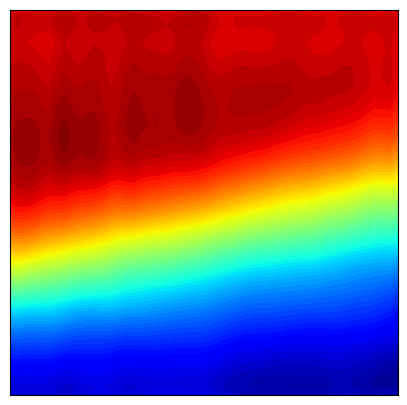

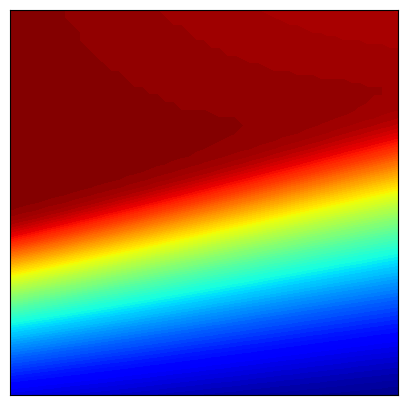

In [12]:
index = 22
x = pred.cpu().detach().numpy()[index].reshape(51,51)
y = y_test.cpu().detach().numpy()[index].reshape(51,51)
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,x,100,cmap='jet')
x1_min, x1_max = axs.get_xlim()
y1_min, y1_max = axs.get_ylim()
axs.set_xticks([])
axs.set_yticks([])
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,y,100,cmap='jet')
axs.set_xlim(x1_min, x1_max)
axs.set_ylim(y1_min, y1_max)
axs.set_xticks([])
axs.set_yticks([])

(96, 51, 51, 1)


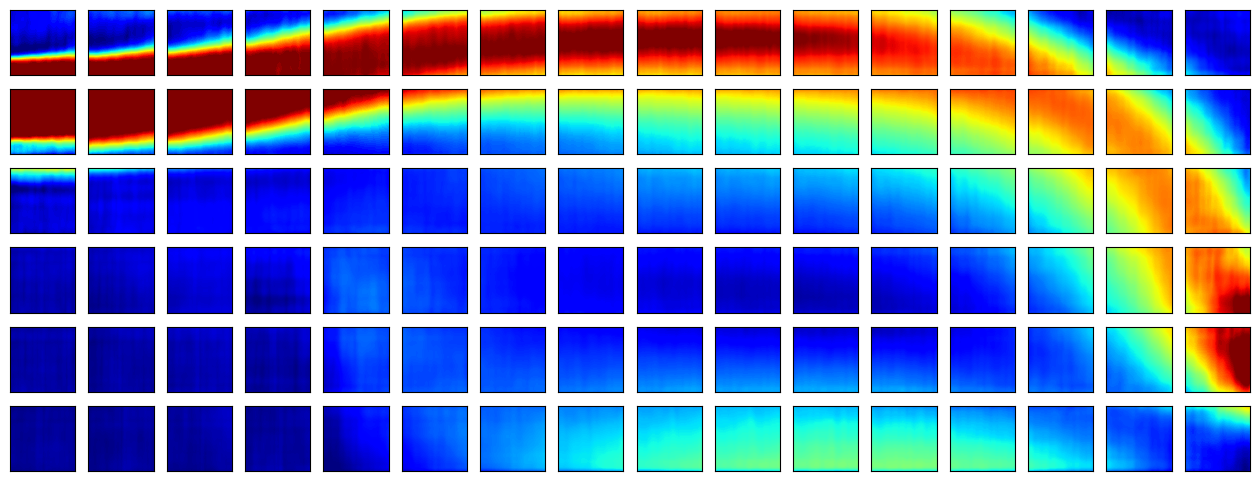

In [63]:
# pred = train_normalizer.decode(pred)
test_x = pred.cpu().detach().numpy()
# test_x[42, :, :, :] = 0
# test_x[43, :, :, :] = 0
# test_x[48, :, :, :] = 0
# test_x[49, :, :, :] = 0
# test_x[9, :, 51:, :] = 0
# test_x[12, :, :51, :] = 0
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(16,6))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], test_x[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

(96, 51, 51, 1)


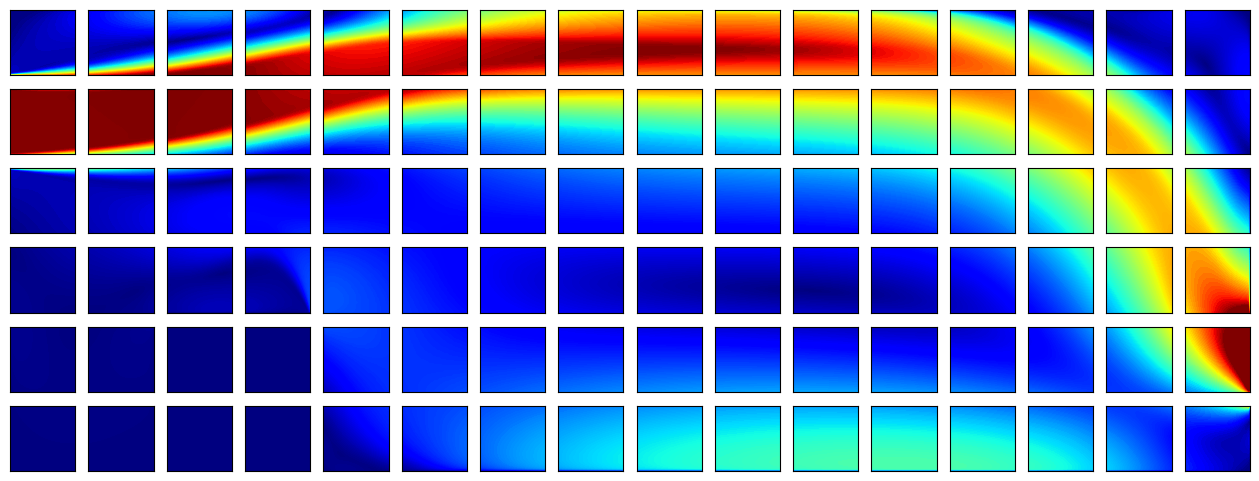

In [64]:
# 真实结果
fig,axs = plt.subplots(n_y,n_x,figsize=(16,6))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], test_label[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

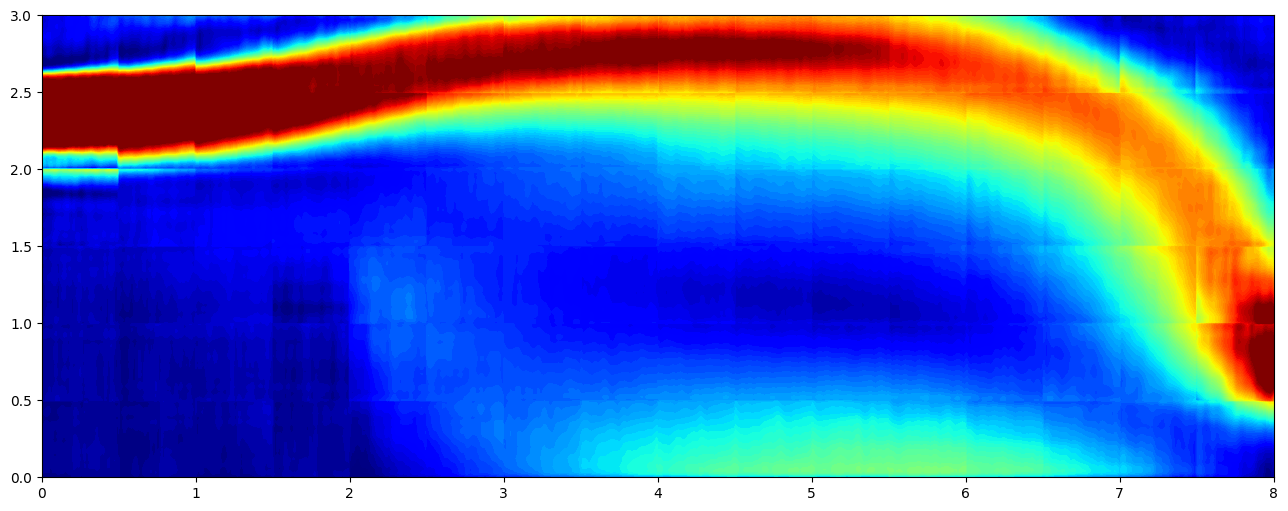

In [65]:
all_zone = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = test_x[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone[-(p_x):,-(p_y):] = test_x[i+j*(n_y),:,:,0]
		else:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

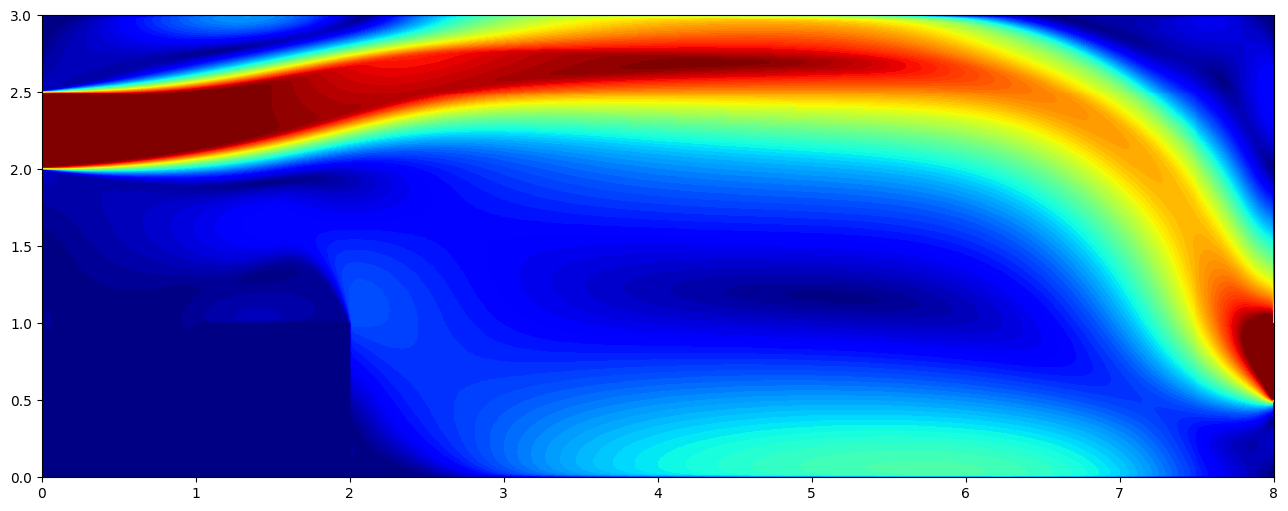

In [66]:
all_zone_truth = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone_truth[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = test_label[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = test_label[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone_truth[-(p_x):,-(p_y):] = test_label[i+j*(n_y),:,:,0]
		else:
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_label[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone_truth,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

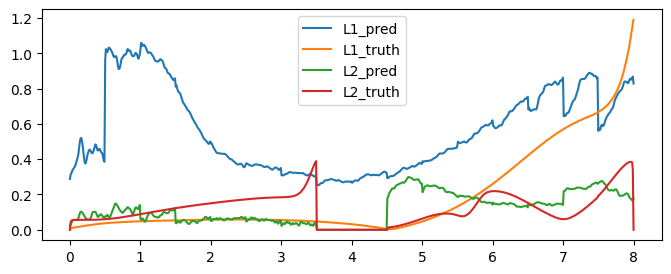

In [51]:
x1_test = all_zone[:,500]
x1_truth = all_zone_truth[:,500]
y1_test = all_zone[225,:]
y1_truth = all_zone_truth[225,:]
y2_test = all_zone[75,:]
y2_truth = all_zone_truth[75,:]
plt.figure(figsize=(8,3))
l1, = plt.plot(np.linspace(0,8,800),y1_test,label='L1_pred')
l2, = plt.plot(np.linspace(0,8,800),y1_truth,label='L1_truth')
L3, = plt.plot(np.linspace(0,8,800),y2_test,label='L2_pred')
L4, = plt.plot(np.linspace(0,8,800),y2_truth,label='L2_truth')
plt.legend(handles=[l1, l2, L3, L4], labels=['L1_pred', 'L1_truth', 'L2_pred', 'L2_truth'], loc='best')


save = False
if save:
	np.savetxt(r'I:\ML\工况合集\预测数据保存\pred_FNO.txt',all_zone)
	np.savetxt(r'I:\ML\工况合集\预测数据保存\truth.txt',all_zone_truth)

[]

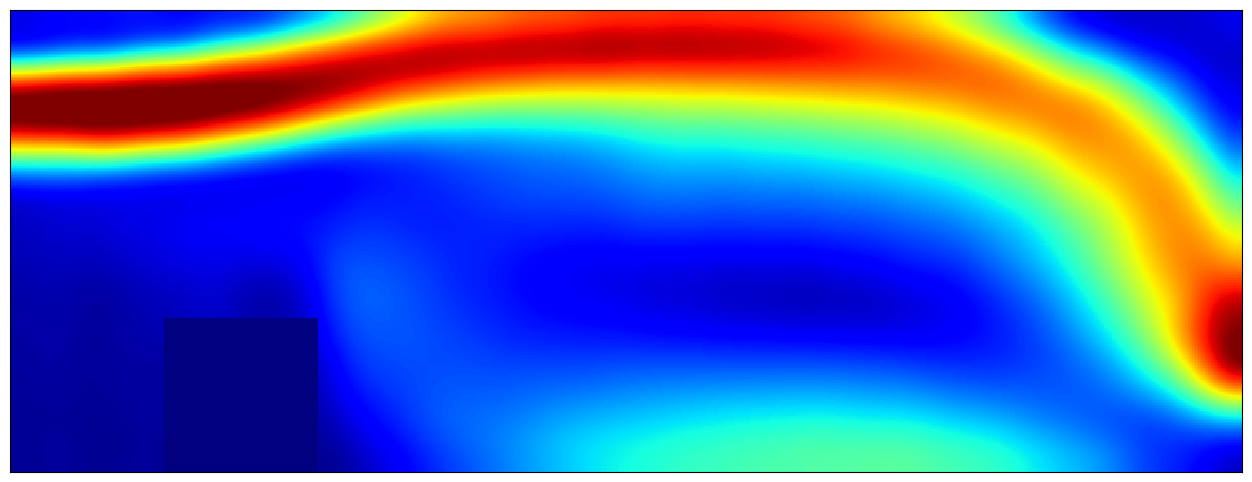

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2


data = all_zone 

sigma = 12  
smoothed_data = gaussian_filter(data, sigma=sigma)

xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

smoothed_data[:100, 100:200] = 0
fig,axs = plt.subplots(1,figsize=(16,6))
axs.pcolor(xnew,ynew,smoothed_data,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])

误差云图

[]

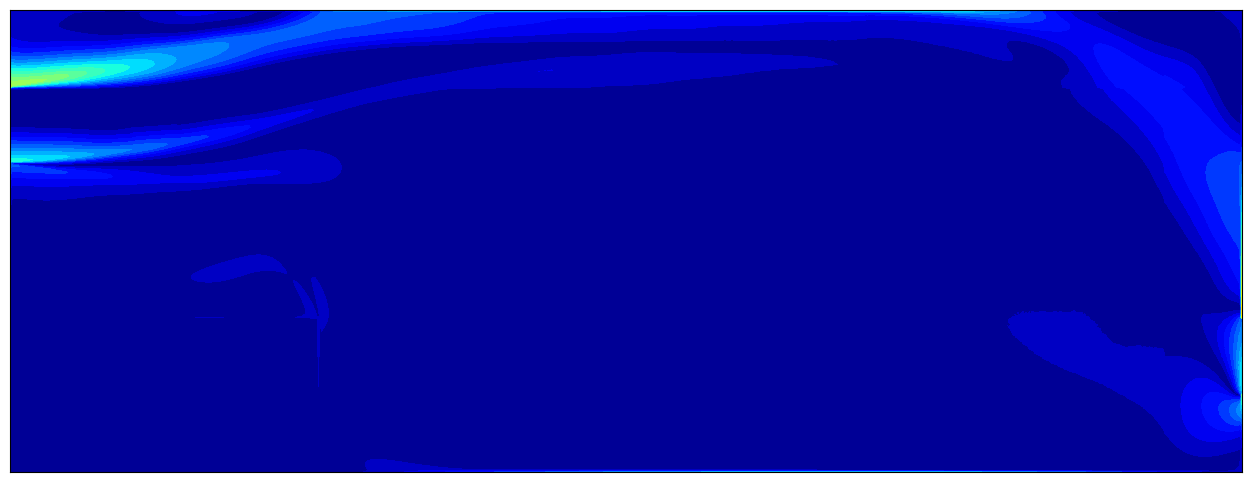

In [68]:
error = np.abs(all_zone_truth-smoothed_data)/np.max(all_zone_truth)
fig,axs = plt.subplots(1,figsize=(16,6))
coontour = axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),error,20,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# colorbar = fig.colorbar(coontour)